In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from omnifold import *

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Global plot settings
import matplotlib.font_manager
plt.rcParams.update({
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 22,
    "xtick.labelsize": 15, 
    "ytick.labelsize": 15, 
    "legend.fontsize":15,
    "legend.frameon": False
})

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

plot_style_3 = {'histtype': 'step', 'linewidth': 2, 'alpha':0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 2.2.0
print(tf.keras.__version__)  # 2.3.0-tf

2.2.0
2.3.0-tf


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generation MC weights from simulated events.

(b) there are generation MC weights from simulated events.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1
fake = 0.1

dummyval = -99

In [7]:
N = 5 * 10**5
# param = (mu, sigma)
sim_param = (mu0, sigma0)  # synthetic sample
data_param = (0.4, 0.8)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

sim_truth = np.random.normal(sim_param[0], sim_param[1],
                             N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weights_MC_sim = np.array([
    (np.random.normal(abs(x), epsilon)) for x in sim_truth
])  # Detector smearing for synthetic sample
weights_MC_sim /= np.mean(weights_MC_sim)
# weights_MC_sim = np.ones_like(sim_truth)

sim_reco = np.array([(x + np.random.normal(0, epsilon)) for x in sim_truth
                     ])  # Detector smearing for synthetic sample
sim = np.stack([sim_truth, sim_reco], axis=1)
labels0 = np.zeros(len(sim))

pass_reco = np.random.binomial(1, 1. - eff, len(sim_truth))
pass_truth = np.random.binomial(1, 1. - fake, len(sim_reco))
for i in range(pass_reco.size):
    if pass_reco[i] == pass_truth[i] == False:
        pass_reco[i] = True
sim_truth[pass_truth == 0] = dummyval
sim_reco[pass_reco == 0] = dummyval

data_truth = np.random.normal(data_param[0], data_param[1], N)
# Toy MC weights from "MC sampling"
weights_MC_data = np.array([(np.random.normal(abs(x), epsilon))
                            for x in data_truth])
weights_MC_data /= np.mean(weights_MC_data)
# weights_MC_data = np.ones_like(data_truth)

# Detector smearing for synthetic sample
data_reco = np.array([(x + np.random.normal(0, epsilon)) for x in data_truth])
data = np.stack([data_truth, data_reco], axis=1)
labels_unknown = np.ones(len(data))

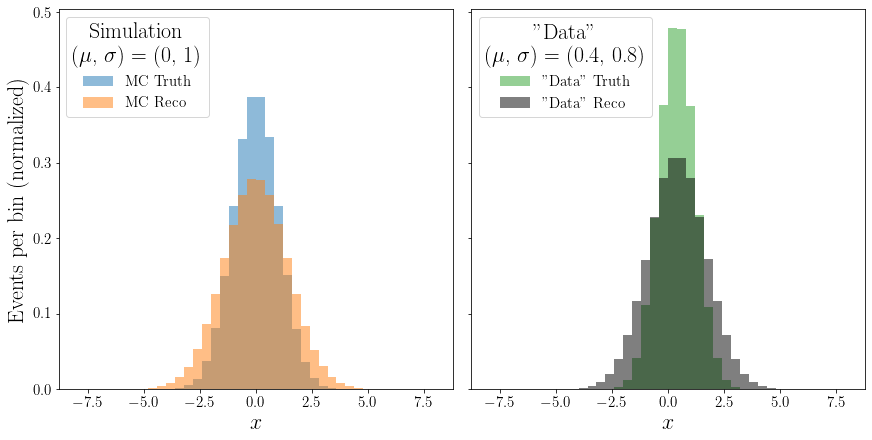

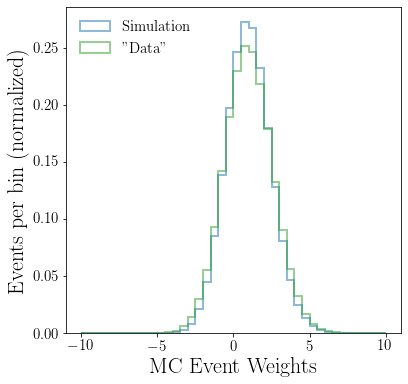

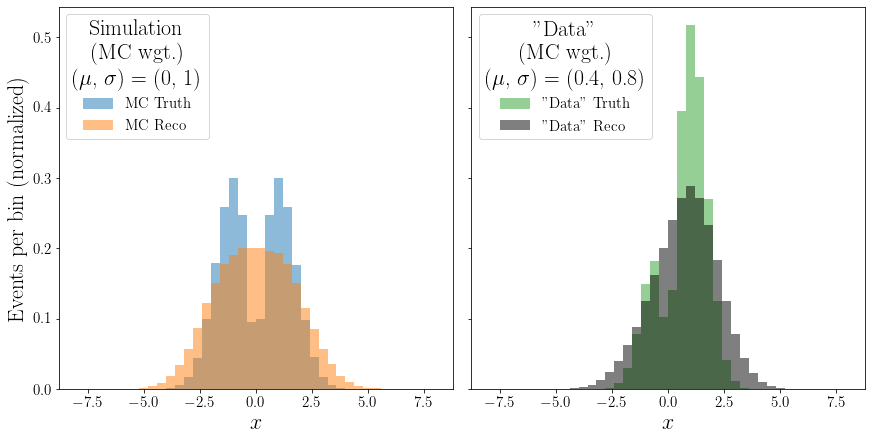

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth, bins=bins, **plot_style_2, label='MC Truth')
ax[0].hist(sim_reco, bins=bins, **plot_style_2, label='MC Reco')
legend = ax[0].legend(
    title='Simulation\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco, bins=bins, **plot_style_2, color='k', label='"Data" Reco')
legend = ax[1].legend(
    title='"Data"\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-Distributions.pdf',
    bbox_inches='tight')
fig.show()

weight_bins = np.linspace( -10, 10, 41)

plt.figure(figsize=(6,6))
plt.hist(weights_MC_sim, bins = weight_bins, color = 'C0', **plot_style_3, label = 'Simulation')
plt.hist(weights_MC_data, bins = weight_bins, color = 'C2', **plot_style_3, label = '"Data"')
plt.xlabel("MC Event Weights")
plt.ylabel("Events per bin (normalized)")
plt.legend(loc='upper left')
plt.show()

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth,
           weights=weights_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Truth')
ax[0].hist(sim_reco,
           weights=weights_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Reco')
legend = ax[0].legend(
    title='Simulation \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='k',
           label='"Data" Reco')
legend = ax[1].legend(
    title='"Data" \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCDistributions.pdf',
    bbox_inches='tight')
fig.show()

## Unfold Data

In [11]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold with initial MC weights

In [12]:
iterations=5

In [13]:
weights, _ = unifold(iterations=iterations,
                     sim_truth=sim_truth,
                     sim_reco=sim_reco,
                     sim_truth_weights_MC=weights_MC_sim,
                     sim_reco_weights_MC=weights_MC_sim,
                     data_reco=data_reco,
                     data_reco_weights_MC=weights_MC_data,
                     dummyval=dummyval,
                     average_weight=True,
                     verbose=1)


ITERATION: 1

STEP 1

Epoch 1/1000
72/72 [==============================] - 0s 5ms/step - loss: 0.6618 - accuracy: 0.2828 - val_loss: 0.6576 - val_accuracy: 0.2845
Epoch 2/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.6570 - accuracy: 0.2850 - val_loss: 0.6573 - val_accuracy: 0.2842
Epoch 3/1000
72/72 [==============================] - 0s 3ms/step - loss: 0.6569 - accuracy: 0.2849 - val_loss: 0.6575 - val_accuracy: 0.2841
Epoch 4/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.2850 - val_loss: 0.6571 - val_accuracy: 0.2840
Epoch 5/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.2849 - val_loss: 0.6572 - val_accuracy: 0.2843
Epoch 6/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.2849 - val_loss: 0.6569 - val_accuracy: 0.2843
Epoch 7/1000
72/72 [==============================] - 0s 4ms/step - loss: 0.6567 - accuracy: 0.2849 - val_loss: 0.6569 - val_

#### Results

ITERATION 1:


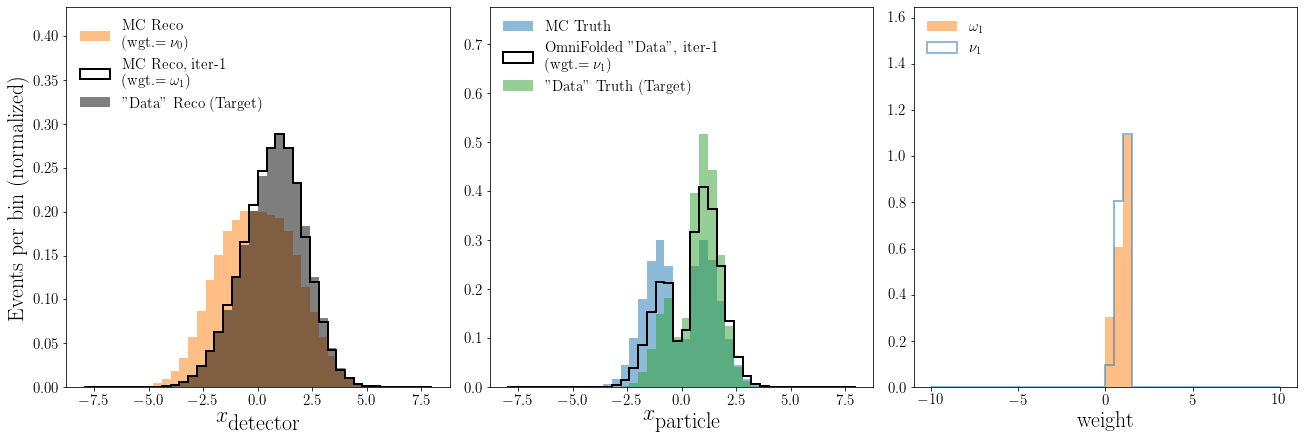

ITERATION 2:


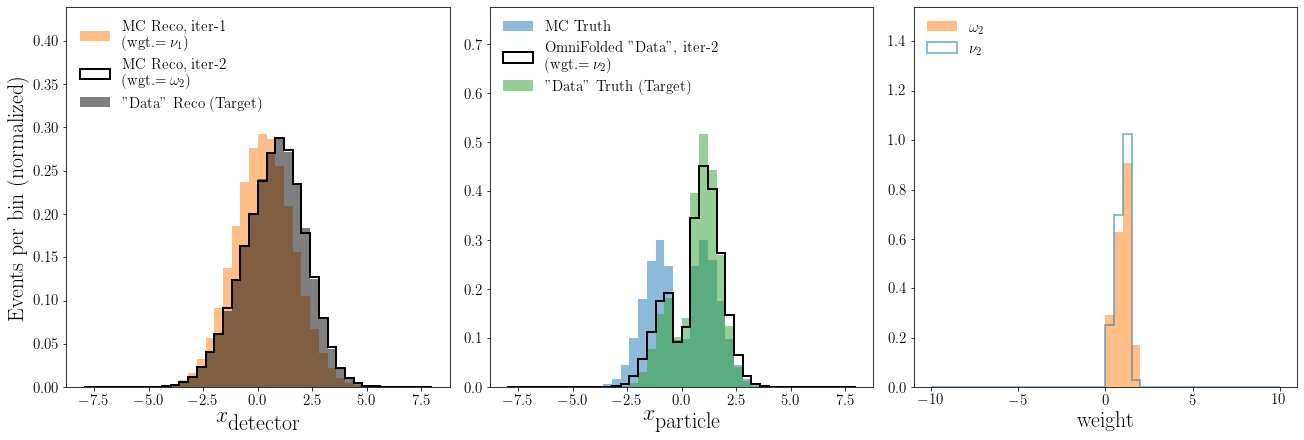

ITERATION 3:


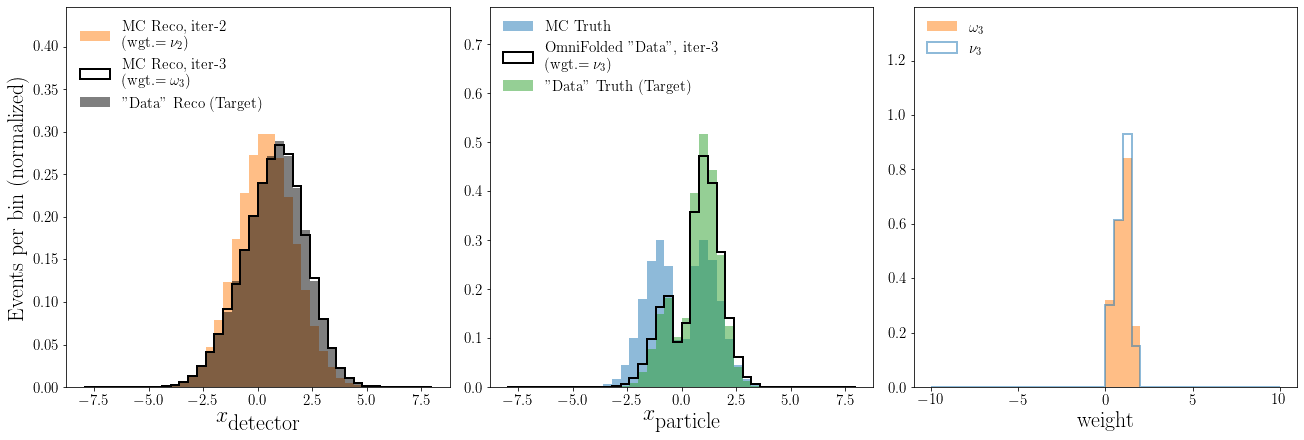

ITERATION 4:


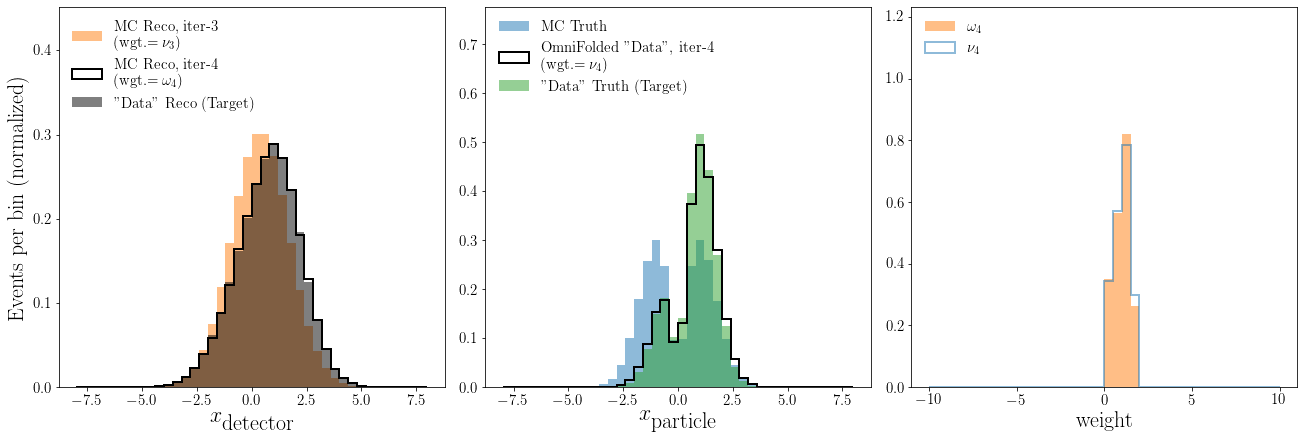

ITERATION 5:


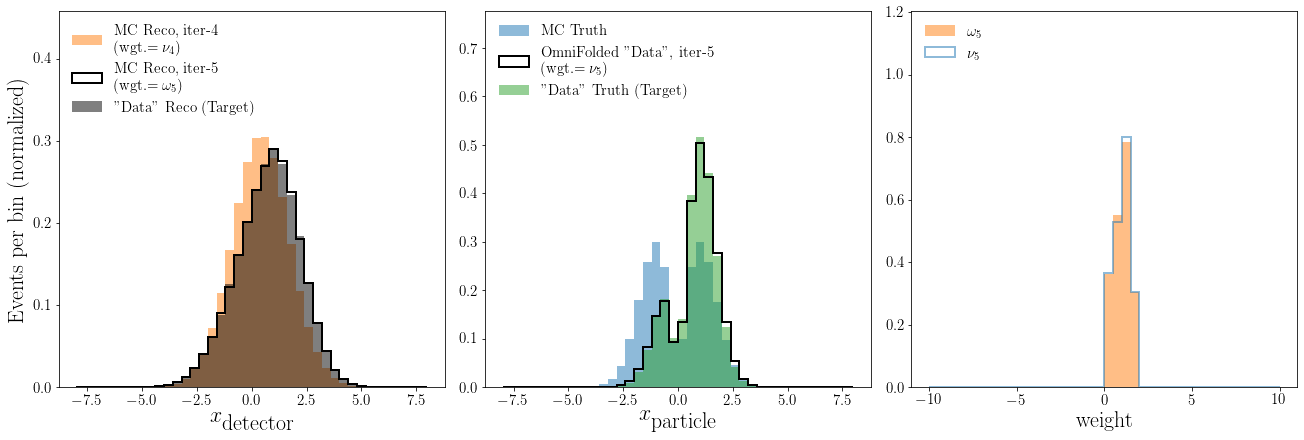

In [14]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           3,
                           figsize=(18, 6),
                           constrained_layout=True,
                           sharey=False)

    if i == 0:
        weights_init = weights_MC_sim
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hT0, _, _ = ax[0].hist(sim_reco,
                           weights=weights_init,
                           bins=bins,
                           label='MC Reco' + label0 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i),
                           **plot_style_2,
                           color='C1')

    hT1, _, _ = ax[0].hist(sim_reco,
                           bins=bins,
                           label='MC Reco' + label1 + '\n' +
                           r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                           weights=weights_MC_sim * weights[i, 0, :],
                           **plot_style_1)
    hT2, _, _ = ax[0].hist(data_reco,
                           weights=weights_MC_data,
                           bins=bins,
                           label='"Data" Reco (Target)',
                           **plot_style_2,
                           color='k')
    ax[0].set_xlabel(r"$x_{\textnormal{detector}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])
    hR0, _, _ = ax[1].hist(sim_truth,
                           weights=weights_MC_sim,
                           bins=bins,
                           label=r'MC Truth',
                           **plot_style_2)

    hR1, _, _ = ax[1].hist(sim_truth,
                           weights=weights_MC_sim * weights[i, 1, :],
                           bins=bins,
                           label='OmniFolded "Data"' + label1 + '\n' +
                           r'(wgt.$=\nu_{{{}}}$)'.format(i + 1),
                           **plot_style_1)
    hR2, _, _ = ax[1].hist(data_truth,
                           weights=weights_MC_data,
                           bins=bins,
                           label='"Data" Truth  (Target)',
                           **plot_style_2,
                           color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textnormal{particle}}$")
    ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])

    #     ax[0].set_ylim(
    #         [0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1, hR2)))])
    hWR, _, _ = ax[2].hist(weights[i, 0, :],
                           bins=weight_bins,
                           **plot_style_2,
                           color='C1',
                           label=r"$\omega_{{{}}}$".format(i + 1))
    hWT, _, _ = ax[2].hist(weights[i, 1, :],
                           bins=weight_bins,
                           **plot_style_3,
                           color='C0',
                           label=r"$\nu_{{{}}}$".format(i + 1))
    ax[2].set_xlabel('weight')
    ax[2].legend(loc='upper left')
    ax[2].set_ylim([0, 1.5 * np.max(np.concatenate((hWR, hWT)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCUnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()